### Import dependencies and define functions needed

In [15]:
import pandas as pd
import math
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from numpy import linalg as la
from pandas_datareader import data as pdr
from matplotlib import ticker 
import matplotlib.pyplot as plt
import statistics
import re


## ----------- FILTER COVID ------------ ##
def filter_covid(df):
    df.reset_index(inplace= True)
    df.set_index('Date', inplace= True)
    mask = (df.index < '2020-01-01') | (df.index  > '2020-09-01')
    no_covid_data = df.loc[mask, :]
    no_covid_data.reset_index
    return no_covid_data

## ----------- GET EIGEN(vectors,values) ----------- ##
def ComputePCA_GPS(S, Srank, Sdim):
# 
#  function to compute PCA and GPS estimators of b given sample cov. matrix S
#  and rank Srank, which will equal the number of periods. 
#  Sdim = size of S = num of assets.
#  There are Srank nonzero evalues, Srank -1 of them below the leading evalue
# 
    evalues, evectors = la.eigh(S)  #  S a sym matrix of size MaxAssets, rank Srank
    h = evectors[:, Sdim - 1]  #  normalized evector corr. to largest evalue of S
    sp2 = evalues[Sdim - 1]  #  leading evalue of S
    lp2 = (np.sum(evalues)-sp2)/(Srank -1) #  average of the lesser nonzero evalues
    psi2 = (sp2 - lp2)/sp2  #  this is the psi^2 term from the GPS paper
    all_ones = np.ones(Sdim)
    q = all_ones/la.norm(all_ones)  #  north pole, unit vector
    
    hq = np.dot(h,q)  #  inner product of h and q
    if hq < 0:
        h = -h      #  choose e-vector h with positive mean
        hq = -hq
    elif hq == 0:
        print("error: h is orthogonal to q")

    tau = (1-psi2)*hq/(psi2 - hq*hq) #  gps data driven shrinkage parameter
    h_shr = h + tau*q   #  h_GPS before normalizing
    return h, (1/la.norm(h_shr))*h_shr, sp2, lp2  #  h and h_GPS, normalized, and sp2, lp2
## ----------- END FUNC ------------ ##


## Continuous Out of Sample Test ##

def continuous_os_Test(period, return_type, num_assets, obs, sample): 
    # pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    sampleData_pct = filter_covid(sampleData_pct)
    ## the rollling out of sample test ##

    varianceJSE = []
    variancePCA = []
    varianceRAW = []
    
    # list of portfolio weights per iteration

    _time = []
    # computeOutSampleVar():
    for i in range(0,len(sampleData_pct)-sample): # subtract observations and 1 since we use these observations and out of sample return
        # DEFINE the new returns array for every new subset
        p_JSE = []
        p_PCA = []
        p_RAW = []
        subset_df = sampleData_pct.iloc[i:sample+i, :] # Grab a subset
        for j in range(0, len(subset_df) - obs - 1):
        # cur_yr = sampleData_pct.reset_index().loc[obs+i, 'Date'].year
        # cur_mo = sampleData_pct.reset_index().loc[obs+i, 'Date'].month
        # cur_day = sampleData_pct.reset_index().loc[obs+i, 'Date'].day
        # _time.append(str(cur_mo) + '-' + str(cur_day) + '-' + str(cur_yr))

            tempdf = subset_df.iloc[j:obs+j, :]
            tempSample_cov = tempdf.cov()

            rank = len(tempdf)
            dimension = len(tempSample_cov)
            
            h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) # leading ev, JSE ev, leading evalue of S, ell^2 
            p_eta_obs = sp2 - lp2
            delta2_raw = ((rank-1)/(dimension-1))*lp2
            delta2_obs = (rank/dimension)*lp2
            p_eta_raw = sp2 - delta2_raw
            
            w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    #  estimated evalues and PCA evector
            w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) #  estimated evalues and GPS evector
            w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) #  PCA evalue and evector
            
            p_JSE.append(np.dot(subset_df.iloc[obs+j, :], w_Ejse)*100)
            p_PCA.append(np.dot(subset_df.iloc[obs+j, :], w_Epca)*100)
            p_RAW.append(np.dot(subset_df.iloc[obs+j, :], w_raw)*100)
            
            # append out-of-sample variance

        varianceJSE.append(statistics.variance(p_JSE))
        variancePCA.append(statistics.variance(p_PCA))
        varianceRAW.append(statistics.variance(p_RAW))

        # end for loop

    # Time analysis for when called

    # first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    # last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    # time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')
        

    return varianceJSE, variancePCA, varianceRAW #_time  variance of portfolio returns

## ----------- COMPUTE THE WEIGHTS ----------- ##
def ComputeMRPortfolio(p, p_eta, delta2, h):

#  outputs w = argmin w^T Sigma w, subj to w^T e = 1.
#  Here Sigma is the real or estimated covariance matrix, depending on inputs
#  p = dimension of Sigma = number of assets
#  p_eta, delta2, h determine Sigma = p_eta hh^T + delta2 I
#  Notation follows MAPS, section 3

    all_ones = np.ones(p)
    q = all_ones/la.norm(all_ones)  #  north pole, unit vector
    hq = np.dot(h,q)

    k2 = delta2/p_eta
    rho = (1+k2)/hq
    w = ((rho*q)-h)/((rho - hq)*np.sqrt(p))
    return w
## ----------- END FUNC ------------ ##



## ----------- IN SAMPLE TEST ----------- ##
def inSampleTest(period: str, return_type: str, num_assets: int, obs: int):
    
# valid periods: '1mo', '3mo', '6mo' ,'1y', '2y', '5y', '10y', 'max' 
# valid time interval: '1d', '5d', '1wk', '1mo', '3mo'
# num_assets x obs is the dimension of the covariance matrix
# period is how long our historical data goes back
# return_type is simply the type of returns we are looking at: 'daily', 'weekly', 'monthly' etc

    # pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    sampleData_pct = filter_covid(sampleData_pct)
    # time

    _time = []

    # variance list
    varJSE = []
    varPCA = []
    varRAW = []

    # list of portfolio weights for each period
    p_JSE = []
    p_PCA = []
    p_RAW = []

    # computeInSampleVar():
    
    for i in range(0,len(sampleData_pct)-obs): # subtract 2 from the length i
        tempdf = sampleData_pct.iloc[i:obs+i, :] # current month frame
        tempSample_cov = tempdf.cov() 
        
        rank = len(tempdf)
        dimension = len(tempSample_cov)

        # time calculation
        cur_yr = sampleData_pct.reset_index().loc[obs+i, 'Date'].year
        cur_mo = sampleData_pct.reset_index().loc[obs+i, 'Date'].month
        cur_day = sampleData_pct.reset_index().loc[obs+i, 'Date'].day
        _time.append(str(cur_mo) + '-' + str(cur_day) + '-' + str(cur_yr))
        
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) # leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    #  estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) #  estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) #  PCA evalue and evector
        
        # all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        # variances
        
        jse_var = np.dot(w_Ejse.T, np.dot(tempSample_cov, w_Ejse))*100
        pca_var = np.dot(w_Epca.T, np.dot(tempSample_cov, w_Epca))*100
        raw_var = np.dot(w_raw.T, np.dot(tempSample_cov, w_raw))*100
        
        # appending current in sample variance to the list
        
        varJSE.append(jse_var)
        varPCA.append(pca_var)
        varRAW.append(raw_var)

    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')

    return varJSE, varPCA, varRAW, _time
## ----------- END FUNC ------------ ##




## ------------ OUT OF SAMPLE TEST -------------- ##
def outSampleTest(period, return_type, num_assets, obs, outOfSample): 
    # pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    sampleData_pct = filter_covid(sampleData_pct)
    ## the rollling out of sample test ##

    varianceJSE = []
    variancePCA = []
    varianceRAW = []
    
    # list of portfolio weights per iteration
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    _time = []
    # computeOutSampleVar():
    
    for i in range(0,len(sampleData_pct)-obs-outOfSample): # subtract 2 from the length i

        tempdf = sampleData_pct.iloc[i:obs+i, :] # current month frame
        tempSample_cov = tempdf.cov()

        cur_yr = sampleData_pct.reset_index().loc[obs+i, 'Date'].year
        cur_mo = sampleData_pct.reset_index().loc[obs+i, 'Date'].month
        cur_day = sampleData_pct.reset_index().loc[obs+i, 'Date'].day
        _time.append(str(cur_mo) + '-' + str(cur_day) + '-' + str(cur_yr))
        

        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) # leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    #  estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) #  estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) #  PCA evalue and evector
        
        # all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        # list of portfolio returns
        
        p_returnJSE = []
        p_returnPCA = []
        p_returnRAW = []
        
        for j in range(obs+i,obs+i+outOfSample):
            p_returnJSE.append(np.dot(sampleData_pct.iloc[j], w_Ejse)*100)
            p_returnPCA.append(np.dot(sampleData_pct.iloc[j], w_Epca)*100)
            p_returnRAW.append(np.dot(sampleData_pct.iloc[j], w_raw)*100)
        
        # append out-of-sample variance

        varianceJSE.append(statistics.variance(p_returnJSE))
        variancePCA.append(statistics.variance(p_returnPCA))
        varianceRAW.append(statistics.variance(p_returnRAW))

        # end for loop

    # Time analysis for when called

    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')
        

    return varianceJSE, variancePCA, varianceRAW, _time # variance of portfolio returns
## ----------- END FUNC ------------ ##

## ------------ OUT OF SAMPLE TEST -------------- ##
def rebalance(period, return_type, num_assets, obs): 
    # pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    # sampleData_pct = filter_covid(sampleData_pct)
    ## collect cumulative returns ##
    ret_JSE = []
    ret_PCA = []
    ret_RAW = []


    
    # list of portfolio weights per iteration
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    _time = []
    # computeOutSampleVar():
    
    # calculates rebalancing frequency based on return type
    if re.search('mo', return_type): # rebalance quarterly (every 3 months)
        rebalancer = 3
    elif re.search('w', return_type): # rebalance monthly (every 4 weeks)
        rebalancer = 4
    elif re.search('d', return_type): # rebalance weekly (every seven days)
        rebalancer = 7
    # initialize weights
    tempdf = sampleData_pct.iloc[0:obs, :] # first time rebalance period
    tempSample_cov = tempdf.cov() # calculate the cov

    rank = len(tempdf) # get the rank
    dimension = len(tempSample_cov) # get the dimension which is just the len of the sample cov
    h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) # leading ev, JSE ev, leading evalue of S, ell^2 
    p_eta_obs = sp2 - lp2
    delta2_raw = ((rank-1)/(dimension-1))*lp2
    delta2_obs = (rank/dimension)*lp2
    p_eta_raw = sp2 - delta2_raw

    w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    #  estimated evalues and PCA evector
    w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) #  estimated evalues and GPS evector
    w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) #  PCA evalue and evector
    
    # list of portfolio returns
    p_returnJSE = [100]
    p_returnPCA = [100]
    p_returnRAW = [100]

    for i in range(1,len(sampleData_pct) - obs - 1): # subtract 2 from the length i
        cur_yr = sampleData_pct.reset_index().loc[obs+i, 'Date'].year
        cur_mo = sampleData_pct.reset_index().loc[obs+i, 'Date'].month
        cur_day = sampleData_pct.reset_index().loc[obs+i, 'Date'].day
        _time.append(str(cur_mo) + '-' + str(cur_day) + '-' + str(cur_yr))
        
        tempdf = sampleData_pct.iloc[i:obs+i, :] # current month frame
        tempSample_cov = tempdf.cov()

        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) # leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        # update portfolio weights if divisible by rebalancer
        if i%rebalancer == 0:
            w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    #  estimated evalues and PCA evector
            w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) #  estimated evalues and GPS evector
            w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) #  PCA evalue and evector
            
        # Keep track of portfolio weights for debugging purposes
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        # portfolio returns + 1 * previous days capital
        p_returnJSE.append((np.dot(sampleData_pct.iloc[i], w_Ejse) + 1) * p_returnJSE[i-1])
        p_returnPCA.append((np.dot(sampleData_pct.iloc[i], w_Epca) + 1) * p_returnJSE[i-1])
        p_returnRAW.append((np.dot(sampleData_pct.iloc[i], w_raw) + 1) * p_returnJSE[i-1])

        # end for loop

    # Time analysis for when called

    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')
        

    return p_returnJSE, p_returnPCA, p_returnRAW, _time, p_JSE # variance of portfolio returns
## ----------- END FUNC ------------ ##

## ----------- REBALANCING TEST -------- ##

# Here we will conduct an out of sample test, rebalancing the portfolio daily (continuosly rebalancing) or monthly. 
# We return our cumulative returns vector for RAW, PCA, and JSE portfolios
# We then calculate annualized return, volatility, max drawdowm


## ----------- BIAS TEST ----------- ##
def biasTest(period, return_type, num_assets, obs, subset: int): 
    # pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    sampleData_pct = filter_covid(sampleData_pct)
    # array of accumulated std
    acc_std = []

    # time array
    _time = []
    # array of portfolio weights
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    # list of returns over standard deviation of model
    pnorm_JSE = []
    pnorm_PCA = []
    pnorm_RAW = []
    
    iterations = 0
    # pnorm_METHOD will be a collection of normalized returns, w
    
    for i in range(0,len(sampleData_pct)-obs-2): # subtract 1 from the length i (we use "next month" data)
        tempdf = sampleData_pct.iloc[i:obs+i, :] # current month frame
        in_sample_mean = tempdf.mean() # series of mean per asset
        tempdf = tempdf.apply(lambda x: x - x.mean(axis = 0)) # demean the asset returns of the current window frame using current asset window frame means
        tempSample_cov = tempdf.cov()
        
        tempdf2 = sampleData_pct.iloc[i:obs+i+1, :]
        tempdf2 = tempdf2 - in_sample_mean
        
        rank = len(tempdf)
        dimension = len(tempSample_cov)

        
        cur_yr = sampleData_pct.reset_index().loc[obs+i, 'Date'].year
        cur_mo = sampleData_pct.reset_index().loc[obs+i, 'Date'].month
        cur_day = sampleData_pct.reset_index().loc[obs+i, 'Date'].day
        _time.append(str(cur_mo) + '-' + str(cur_day) + '-' + str(cur_yr))

        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) # leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    #  estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) #  estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) #  PCA evalue and evector
        
        # all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        # std of model
        
        cur_jse_std = math.sqrt(np.dot(w_Ejse, np.dot(tempSample_cov, w_Ejse)))
        cur_pca_std = math.sqrt(np.dot(w_Epca, np.dot(tempSample_cov, w_Epca)))
        cur_raw_std = math.sqrt(np.dot(w_raw, np.dot(tempSample_cov, w_raw)))
        
        # next month portoflios return/std

        pnorm_JSE.append((np.dot(tempdf2.iloc[-1], w_Ejse))/cur_jse_std)
        pnorm_PCA.append((np.dot(tempdf2.iloc[-1], w_Epca))/cur_pca_std)
        pnorm_RAW.append((np.dot(tempdf2.iloc[-1], w_raw))/cur_raw_std)
        
        iterations += 1

    subJSE = []
    subRAW = []
    subPCA = []
    time_slice = _time[subset:]
    for i in range(iterations-subset): 
        subJSE.append(np.std(pnorm_JSE[i:subset+i]))
        subRAW.append(np.std(pnorm_RAW[i:subset+i]))
        subPCA.append(np.std(pnorm_PCA[i:subset+i]))

    # test to see how many intervals or subset required: 

    for i in range(len(pnorm_JSE)):
        acc_std.append(np.std(pnorm_JSE[0:i]))


    # we will try and get the time horizon to print return a string: 4/1/20 - 8/1/22

    # first we need to get the first date of the the first data frame
 
    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')

    return subJSE, subPCA, subRAW, iterations, time_slice, acc_std

## ----------- END FUNC ------------ ##

In [55]:
varJSE_new, varPCA_new, varRAW_new = continuous_os_Test('10y', '1mo', 100, 24,50)

[*********************100%***********************]  100 of 100 completed


In [56]:
len(varJSE_new)

61

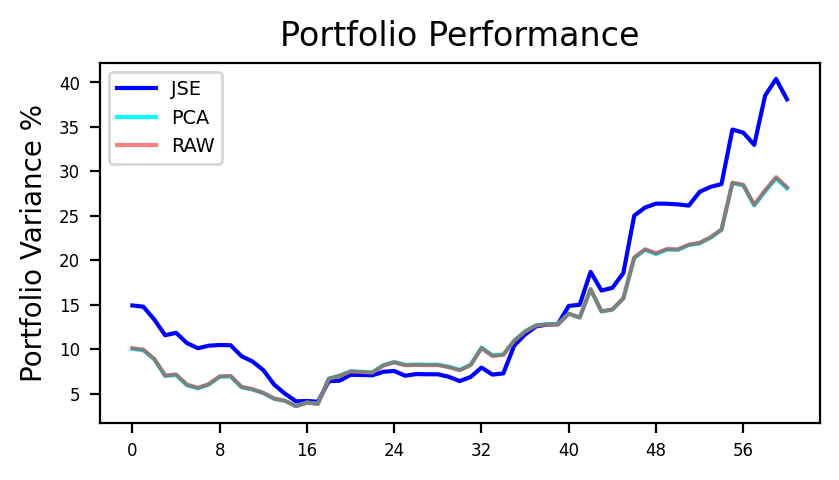

In [57]:
fig_0 = plt.figure(figsize=(4,2), dpi = 200)
axes_0 = fig_0.add_axes([0.1,0.1, 0.9, 0.9])
axes_0.xaxis.set_major_locator(ticker.MaxNLocator())
axes_0.tick_params(labelsize = 6)
axes_0.set_ylabel('Portfolio Variance %')
axes_0.set_title(f'Portfolio Performance')
axes_0.plot(varJSE_new, label = 'JSE', color = '#0000FF', alpha = 1)
axes_0.plot(varPCA_new, label = 'PCA', color = '#00FFFF')
axes_0.plot(varRAW_new, label = 'RAW', color = 'red', alpha = 0.5)
axes_0.legend(loc = 0, fontsize = 'x-small') # upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants


In [ ]:
reb_period = '10y'
reb_return_type = '1mo'
retJSE, retPCA, retRAW, reb_time, weights = rebalance(reb_period, reb_return_type, 100, 50)

In [ ]:
statistics.variance()

In [ ]:
reb_time.append(reb_time[-1])

In [ ]:
fig_0 = plt.figure(figsize=(4,2), dpi = 200)
axes_0 = fig_0.add_axes([0.1,0.1, 0.9, 0.9])
axes_0.xaxis.set_major_locator(ticker.MaxNLocator())
axes_0.tick_params(labelsize = 6)
axes_0.set_ylabel('Portfolio')
axes_0.set_title(f'Portfolio Performance {reb_period}/{reb_return_type}')
axes_0.plot(reb_time, retJSE, label = 'JSE', color = '#0000FF', linewidth = 0.5, alpha = 1)
axes_0.plot(reb_time, retPCA, label = 'PCA', color = '#00FFFF', linewidth = 0.5)
axes_0.plot(reb_time, retRAW, label = 'RAW', color = 'red', linewidth = 0.5)
axes_0.legend(loc = 0, fontsize = 'x-small') # upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants

fig_0.autofmt_xdate()

###  In sample test

In [ ]:
is_period = '5y'
is_return_type = '1d'
is_varJSE, is_varPCA, is_varRAW, is_time = inSampleTest(is_period, is_return_type, 100, 50)

In [ ]:

fig_1 = plt.figure(figsize=(4,2), dpi = 200)
axes_1 = fig_1.add_axes([0.1,0.1, 0.9, 0.9])
axes_1.xaxis.set_major_locator(ticker.MaxNLocator())
axes_1.tick_params(labelsize = 6)
axes_1.set_ylabel('Portfolio Variance %')
axes_1.set_title(f'In Sample {is_period}/{is_return_type}')
axes_1.plot(is_time, is_varJSE, label = 'JSE', color = '#0000FF')
axes_1.plot(is_time, is_varPCA, label = 'PCA', color = '#00FFFF')
axes_1.plot(is_time, is_varRAW, label = 'RAW', color = 'red', alpha = 0.4)
axes_1.legend(loc = 0, fontsize = 'x-small') # upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants

fig_1.autofmt_xdate()

fig_1.savefig(f"in sample {is_period}_{is_return_type}", dpi = 400, facecolor = 'w', bbox_inches = 'tight')

###  Out of sample test

In [58]:
os_period = '15y'
os_return_type = '1mo'
os_varJSE, os_varPCA, os_varRAW, os_time = outSampleTest(os_period, os_return_type, 100,24,6)

[*********************100%***********************]  100 of 100 completed


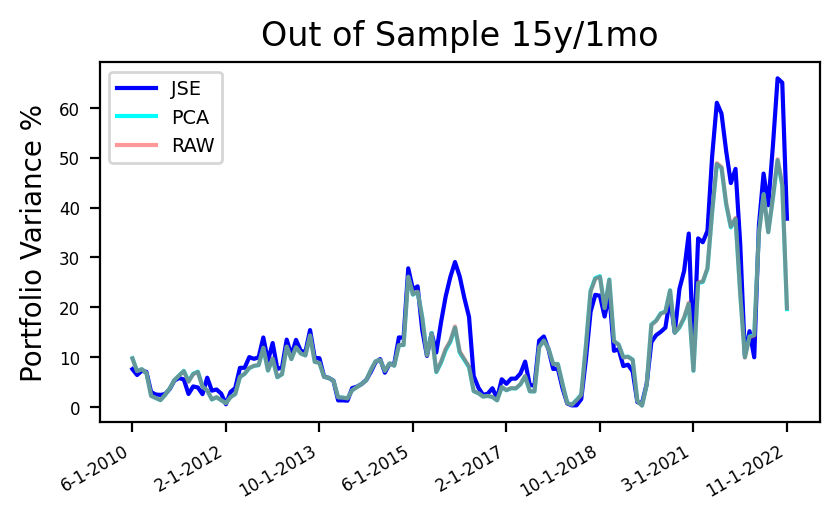

In [59]:


fig_1 = plt.figure(figsize=(4,2), dpi = 200)
axes_1 = fig_1.add_axes([0.1,0.1, 0.9, 0.9])
axes_1.xaxis.set_major_locator(ticker.MaxNLocator())
axes_1.tick_params(labelsize = 6)
axes_1.set_ylabel('Portfolio Variance %')
axes_1.set_title(f'Out of Sample {os_period}/{os_return_type}')
axes_1.plot(os_time, os_varJSE, label = 'JSE', color = '#0000FF')
axes_1.plot(os_time, os_varPCA, label = 'PCA', color = '#00FFFF')
axes_1.plot(os_time, os_varRAW, label = 'RAW', color = 'red', alpha = 0.4)
axes_1.legend(loc = 0, fontsize = 'x-small') # upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants

fig_1.autofmt_xdate()

fig_1.savefig(f"out sample {os_period}_{os_return_type}", dpi = 400, facecolor = 'w', bbox_inches = 'tight')

### Bias test


Consider a sequence of out of sample demeaned portfolio returns $ x^{(1)}, x^{(2)}, ... , x^{(n)} $. Then suppose that we have the correct estimator for the standard deviation in the forecast, i.e. we have solved 
\begin{align}
w_{true} = \text{arg min} \sqrt{w^T \Sigma w} \nonumber
\end{align} 
using the true covariance matrix of asset returns, or $\Sigma$. Now consider the following sequence of random variables: 
\begin{equation}
\frac{x^{(1)}}{\sigma_{true}}, \frac{x^{(2)}}{\sigma_{true}}, ..., \frac{x^{(n)}}{\sigma_{true}}
\end{equation}
where $x^{(i)}$ is the out of sample return of $w_{true}$, and $\sigma_{true}$ is true standard deviation of the minimum variance portfolio. Although we cannot achieve this sequence with historical data, if we could, then we would essentially be drawing returns from a distribution with that specific standard deviation (true min var portfolio std). So if we were to take a large enough subset of (1), assuming n is sufficiently large, the standard deviation of this subset is going to be $\approx 1$.

Now although we do not have $\Sigma$, and thus can't solve for $w_{true}$, we can use this normazliation technique to decide which $\hat{\Sigma}$ is closest to the true covariance matrix. This would lead us to arriving at weights which are closest to $w_{true}$. Now with a better solution of $w$, the closer the standard deviation of a subset of (1) will be to 1.  

However, since we rely on data, the process will be different. Specifically (1) will become:

\begin{equation}\tag{2}
\frac{x_{JSE}^{(1)}}{\sigma_{JSE}^{(1)}}, \frac{x_{JSE}^{(2)}}{\sigma_{JSE}^{(2)}}, ..., \frac{x_{JSE}^{(n)}}{\sigma_{JSE}^{(n)}}
\end{equation}

where $x_{JSE}^{(i)}$ is calculated using $w_{JSE}^{(i)}$, and $\sigma_{JSE}^{(i)}$ is simply the standard deviation of the model at that time step. We can view each element of this sequence as a normalized random variable whose standard deviation *should* be one. We capture a large sequence of these random variables and utilize a sliding window technique to take standard deviations accordingly. We then plot these standard deviations as a function of steps in the sliding window. These calculations are also made for PCA and RAW covariance matrices.  

In order to identify how large the subset must be, we take accumulated standard deviations to see the speed of convergence towards one.


In [40]:
# good to try
# 10y, 1mo, 50, 24
# 1y, 1d, 50, 24
# 3y, 1d, 5

bias_period = '10y'
bias_returntype = '1mo'
bias_num_assets = 100
bias_obs = 50
subset = 20
subJSE, subPCA, subRAW, iterations, time_slice, acc_std = biasTest(bias_period, bias_returntype, bias_num_assets, bias_obs, subset)

[*********************100%***********************]  100 of 100 completed


c:\Users\Simon Ribas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Simon Ribas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\Simon Ribas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


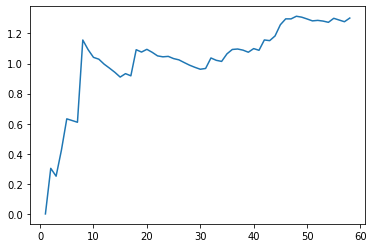

In [41]:
plt.plot(acc_std)

In [42]:
len(subJSE)



39

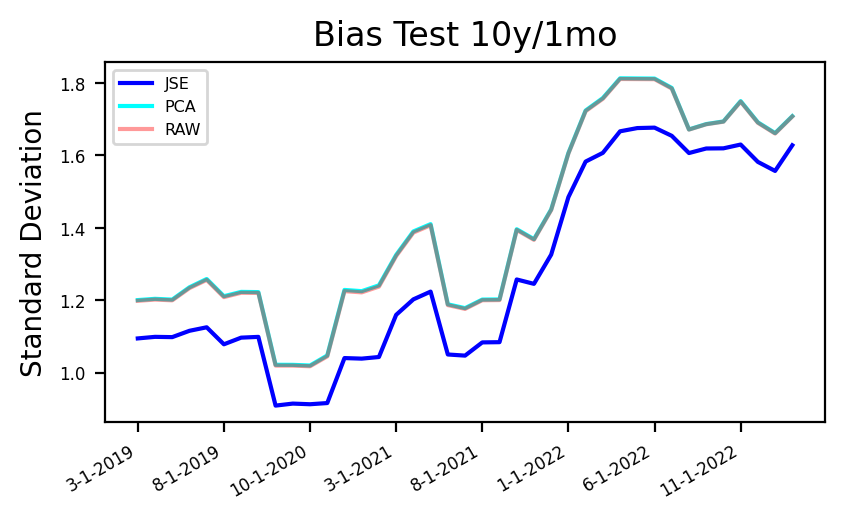

In [43]:
fig_2 = plt.figure(figsize=(4,2), dpi = 200)
axes_2 = fig_2.add_axes([0.1,0.1, 0.9, 0.9])
axes_2.xaxis.set_major_locator(ticker.MaxNLocator())
axes_2.tick_params(labelsize = 6)
axes_2.set_ylabel('Standard Deviation')
axes_2.set_title(f'Bias Test {bias_period}/{bias_returntype}')
axes_2.plot(time_slice,subJSE, label = 'JSE', color = '#0000FF')
axes_2.plot(time_slice,subPCA, label = 'PCA', color = '#00FFFF')
axes_2.plot(time_slice,subRAW, label = 'RAW', color = 'red', alpha = 0.4)
axes_2.legend(loc = 2, fontsize = 'xx-small') # upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants

fig_2.autofmt_xdate()

fig_2.savefig(f"bias test {bias_period}_{bias_returntype}", dpi = 400, facecolor = 'w', bbox_inches = 'tight')


In [35]:
period = '1y'
return_type = '1mo'
bias_num_assets = 100
bias_obs = 50
subset = 20
df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
df = df.iloc[0:5]
tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
sampleData_pct = sampleData.pct_change()
sampleData_pct.dropna(inplace = True)

[*********************100%***********************]  5 of 5 completed


In [ ]:

tempdf = sampleData_pct.iloc[0:5, :] # current month frame
# tempdf = tempdf.apply(lambda x: x - x.mean(axis = 0)) # demean the asset returns of the current window frame using current asset window frame means
tempSample_cov = tempdf.cov()
tempdf.mean()

In [ ]:

tempdf2 = sampleData_pct.iloc[0:6, :]
tempdf2 - tempdf.mean()

In [ ]:
tempdf

In [ ]:
no_covid_data = tempdf.loc[:, [col for col in tempdf.columns if col < '2022-08-01' or col > '2020-05-01']]

In [ ]:
no_covid_data

In [ ]:
tempdf.reset_index(inplace= True)

In [ ]:
tempdf.set_index('Date', inplace = True)

In [ ]:
mask = (tempdf.index < '2022-07-01') | (tempdf.index  > '2022-08-01')
no_covid_data = tempdf.loc[mask, :]

In [ ]:
no_covid_data.reset_index()

In [ ]:
tempdf.index